# Libraries          
---

In [1]:
# 기본
import pandas as pd
import numpy as np 
import os
import warnings
warnings.filterwarnings("ignore")

# 시각화 
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns

# 모델
from sklearn.model_selection import (train_test_split, 
                                     KFold, 
                                     StratifiedKFold,
                                     GridSearchCV,
                                     RandomizedSearchCV)

from sklearn.tree import (DecisionTreeClassifier, 
                          DecisionTreeRegressor)

from sklearn.ensemble import (RandomForestClassifier, 
                              RandomForestRegressor)

from sklearn.svm import SVC

from xgboost import XGBClassifier

# sampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# report
from sklearn import metrics
# matrix = metrics.confusion_matrix(y_test, y_pred)
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score

#encoder, scaler
from sklearn.preprocessing import (LabelEncoder, 
                                   OneHotEncoder, 
                                   StandardScaler,
                                   MinMaxScaler)

# imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# test
import statsmodels.api as sm 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(context = 'talk',  
              style = 'darkgrid',  
              font = 'Malgun Gothic', 
              font_scale = 1.2,         
              rc = custom_params) 

# Read the Data           
---

In [3]:
cur_dir = os.getcwd()

for root, dirs, files in os.walk(cur_dir):
    if ".git" not in root:
        print(root, files)

c:\Users\jaekyung\Documents\ML ['.gitignore', '004. 만료및탈퇴 회원 예측_보완.ipynb', '1company_rating.ipynb', '1Heart_Disease.ipynb', '1Heart_Disease_re.ipynb', '1Insurance_charge.ipynb', '1project_pre.ipynb', 'graph.txt', 'Libraries.ipynb', 'modeling checklist.ipynb', 'Mv_txt.ipynb', 'pre.txt', 'project_prep.ipynb', 'scikit-learn.ipynb', 'SMOTE-Oversampling.ipynb', 'validation.ipynb', '분석기법별 특징.png']
c:\Users\jaekyung\Documents\ML\.vscode ['settings.json']
c:\Users\jaekyung\Documents\ML\data ['heart_disease_uci.csv', 'ObesityDataSet.csv']


In [6]:
data_list = os.listdir(cur_dir + "\data")
Dataset = dict()

for data in data_list:
    if ".csv" in data:
        Dataset[data[:-4]] = pd.read_csv(cur_dir + f"\data\{data}")

In [7]:
data = Dataset['heart_disease_uci']
df = data.copy()

In [8]:
df.head(3)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1


# Data info          
---

In [9]:
df_null = df.isna().sum().reset_index()
df_nunique = df.nunique().reset_index()
df_dtypes = df.dtypes.reset_index()

df_info = pd.merge(df_null, df_nunique, on = "index", how = "left")
df_info = pd.merge(df_info, df_dtypes, on = 'index', how = "left")

df_info['null_ratio'] = round(df_info['0_x'] / len(df) * 100, 2).astype('str') + "%"
df_info = df_info.rename(columns = {"index":"col",'0_x':"null_count","0_y":"nunique_count",0:"dtypes"})
df_info = df_info[["col", "null_count", "null_ratio", "nunique_count", "dtypes"]]
print(f"Data\n\nIndex: {df.shape[0]}\nColumns: {df.shape[1]}")
df_info

Data

Index: 920
Columns: 16


,col,null_count,null_ratio,nunique_count,dtypes
0,id,0,0.0%,920,int64
1,age,0,0.0%,50,int64
2,sex,0,0.0%,2,object
3,dataset,0,0.0%,4,object
4,cp,0,0.0%,4,object
5,trestbps,59,6.41%,61,float64
6,chol,30,3.26%,217,float64
7,fbs,90,9.78%,2,object
8,restecg,2,0.22%,3,object
9,thalch,55,5.98%,119,float64


In [11]:
df.duplicated().sum()

0

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


# Data EDA      
---

## Numeric

In [16]:
numeric_df = df.select_dtypes(include = "number")
numeric_df.head(2)

,age,trestbps,chol,thalch,oldpeak,ca,num
0,63,145.0,233.0,150.0,2.3,0.0,0
1,67,160.0,286.0,108.0,1.5,3.0,2


In [21]:
for fig ,col in enumerate((numeric_df.columns)):
    fig = px.histogram(numeric_df[col],
                       marginal = "box",
                       color_discrete_sequence = ["#3F72AF"],
                       nbins = numeric_df[col].nunique())
    fig.update_layout(title = f"{col}", bargap = 0.1)
    fig.show()

## Categoric

In [26]:
categorical_df = df.select_dtypes(include = "object")
categorical_df.head(2)

,sex,cp,fbs,restecg,exang,slope,thal
0,Male,typical angina,True,lv hypertrophy,False,downsloping,fixed defect
1,Male,asymptomatic,False,lv hypertrophy,True,flat,normal


In [28]:
for fig ,col in enumerate((categorical_df.columns)):
    fig = px.histogram(categorical_df[col],
                       marginal = "rug",
                       color_discrete_sequence = ["#3F72AF"],
                       nbins = categorical_df[col].nunique())
    fig.update_layout(title = f"{col}", bargap = 0.1)
    fig.show()

## Data visualization

In [29]:
px.scatter(data_frame= df[['age','num','sex','trestbps']], x = 'age', y = 'trestbps', color = 'num', symbol = 'sex',
           marginal_x = 'histogram',
           marginal_y = 'rug')

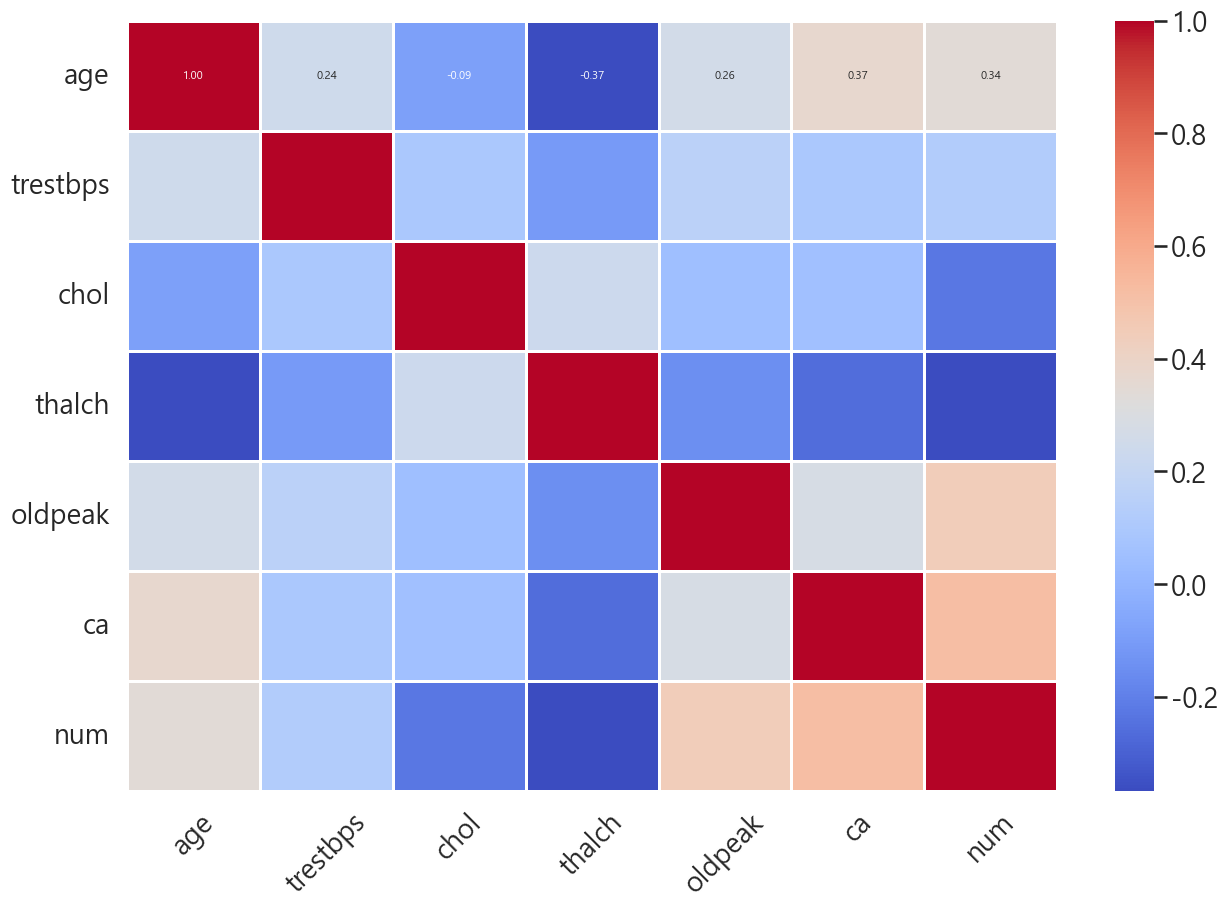

In [41]:
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(df.select_dtypes(include="number").corr(method="pearson"), cmap="coolwarm", annot=True, fmt=".2f", linewidths=2, annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.show()

In [43]:
df.select_dtypes(include = "number").corr()[df.select_dtypes(include = "number").corr() > 0.8].fillna('')

,age,trestbps,chol,thalch,oldpeak,ca,num
age,1.0,,,,,,
trestbps,,1.0,,,,,
chol,,,1.0,,,,
thalch,,,,1.0,,,
oldpeak,,,,,1.0,,
ca,,,,,,1.0,
num,,,,,,,1.0


<Axes: >

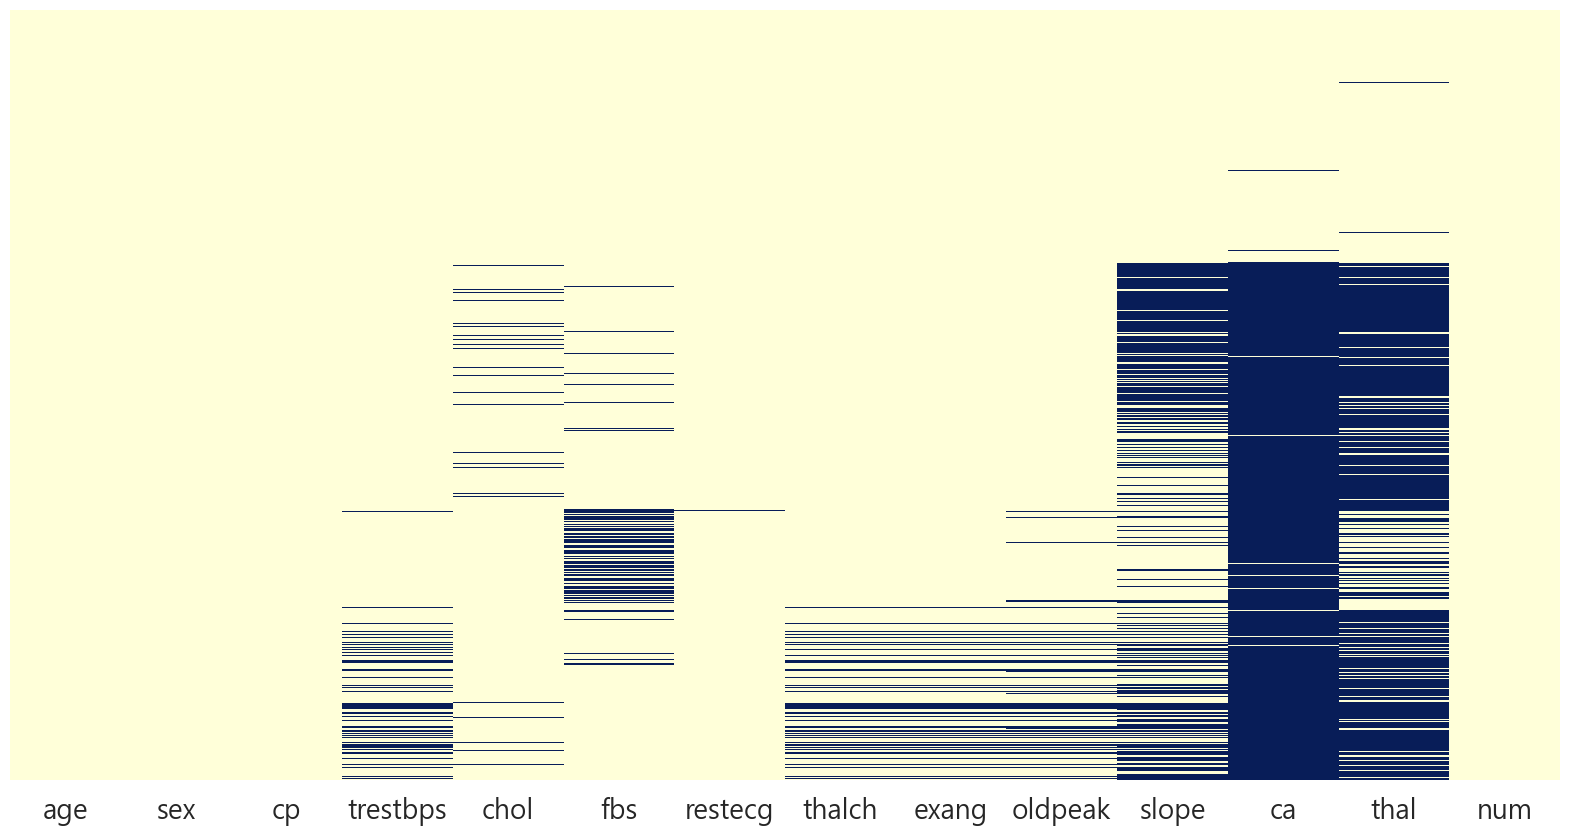

In [45]:
plt.figure(figsize = (20, 10))
sns.heatmap(data = df.isna(), yticklabels = False, cbar = False, cmap = 'YlGnBu')

# Missing values: Iterative imputer - random forest        
---

## Iterative imputer - random forest

In [48]:
df_missing_cols = []
for col in df.isna().sum()[df.isna().sum() > 0].sort_values(ascending = False).index:
    df_missing_cols.append(col)

df_missing_cols

['ca',
 'thal',
 'slope',
 'fbs',
 'oldpeak',
 'trestbps',
 'thalch',
 'exang',
 'chol',
 'restecg']

In [47]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numeric_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [ ]:
def cat_missing(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(columns = passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in df_missing_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=777), add_indicator = True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    X = df_null.drop(columns = passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def num_missing(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(columns = passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in df_missing_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=777), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)
    
    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [ ]:
for col in df_missing_cols:
    if col in categorical_cols:
        df[col] = cat_missing(col)
    elif col in numeric_cols:
        df[col] = num_missing(col)
    else:
        pass

In [ ]:
df_null = df.isna().sum().reset_index()
df_nunique = df.nunique().reset_index()
df_dtypes = df.dtypes.reset_index()

df_info = pd.merge(df_null, df_nunique, on = "index", how = "left")
df_info = pd.merge(df_info, df_dtypes, on = 'index', how = "left")

df_info['null_ratio'] = round(df_info['0_x'] / len(df) * 100, 2).astype('str') + "%"
df_info = df_info.rename(columns = {"index":"col",'0_x':"null_count","0_y":"nunique_count",0:"dtypes"})
df_info = df_info[["col", "null_count", "null_ratio", "nunique_count", "dtypes"]]
print(f"Data\n\nIndex: {df.shape[0]}\nColumns: {df.shape[1]}")
df_info

## model

### visualization

In [ ]:
X = df.drop(columns = "target")
y = df.target

In [ ]:
pca = PCA(n_components = 14, random_state = 777)
X_pca = pca.fit_transform(X)
df_X = pd.DataFrame(X_pca)
sns.clustermap(df_X, standard_scale = 1)
plt.show()

### train test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 777, test_size = .2)

### Random forest

In [ ]:
RF = RandomForestClassifier(random_state = 777)
RF.fit(X_train, y_train)

y_RF_pred = RF.predict(X_test)

print(classification_report(y_test, y_RF_pred))

In [ ]:
parameters = {'max_depth': range(1,10), 'min_samples_split': range(2,5)}

grid_dt = GridSearchCV(RF, param_grid = parameters, cv=3, refit=True, return_train_score=True)
grid_dt.fit(X_train, y_train)

# GridSearchCV result
# scores_df = pd.DataFrame(grid_dt.cv_results_)
# scores_df[['params', 'mean_test_score', 'rank_test_score',
#            'split0_test_score', 'split1_test_score', 'split2_test_score']]

print(f'best params:', grid_dt.best_params_)
print(f'best score {grid_dt.best_score_:.2%}')

In [ ]:
RF = RandomForestClassifier(random_state = 777, max_depth = , min_samples_split = )
RF.fit(X_train, y_train)

y_RF_pred = RF.predict(X_test)

print(classification_report(y_test, y_RF_pred))

### xgboost

In [ ]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

y_XGB_pred = XGB.predict(X_test)

print(classification_report(y_test, y_XGB_pred))

## model 조정 - RF

### Tsme

In [ ]:
tmodel = TSNE(n_components=2)
x_embed = tmodel.fit_transform(X_test)

In [ ]:
print(classification_report(y_test, y_RF_pred))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color = y_test, symbol = y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color = y_RF_pred, symbol = y_RF_pred, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

### proba

In [ ]:
y_RF_param_proba = RF.predict_proba(X_test)
print(y_RF_param_proba)

### Matrix

In [ ]:
RF_matrix = metrics.confusion_matrix(y_true = y_test, y_pred = y_RF_pred)
print(f"Matrix:\n\n{RF_matrix}")

In [ ]:
sns.heatmap(RF_matrix, cmap = "coolwarm", annot = True)

### Feature importance

In [ ]:
for name, value in zip(X_train.columns, RF.feature_importances_):
    print(f"{name}: {value: %}")

In [ ]:
ax = sns.barplot(x = RF.feature_importances_ , y = X_test.columns, color = "#3F72AF")
ax.bar_label(ax.containers[0], fmt='  %.3f')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('RF Feature Importances')
plt.show()

### Roc

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_RF_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#3F72AF', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC Curve')
plt.legend(loc="lower right")
plt.show()

## model 조정 - XGboost

### Tsme

In [ ]:
print(classification_report(y_test, y_XGB_pred))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color = y_test, symbol = y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color = y_XGB_pred, symbol = y_XGB_pred, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

### proba

In [ ]:
y_RF_param_proba = XGB.predict_proba(X_test)
print(y_RF_param_proba)

### Matrix

In [ ]:
XGB_matrix = metrics.confusion_matrix(y_true = y_test, y_pred = y_XGB_pred)
print(f"Matrix:\n\n{XGB_matrix}")

In [ ]:
sns.heatmap(XGB_matrix, cmap = "coolwarm", annot = True)

### Feature importance

In [ ]:
for name, value in zip(X_test.columns, XGB.feature_importances_):
    print(f"{name}: {value: %}")

In [ ]:
ax = sns.barplot(x = XGB.feature_importances_ , y = X_test.columns, color = "#3F72AF")
ax.bar_label(ax.containers[0], fmt='  %.3f')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('RF Feature Importances')
plt.show()

### Roc

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_XGB_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#3F72AF', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Missing values: drop      
---

## Drop

In [52]:
df_drop = data.copy()

In [53]:
df_drop.dropna(inplace = True)

In [55]:
df_drop.isna().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

## Model

### visualization

In [ ]:
X_d = df_drop.drop(columns = "target")
y_d = df_drop.target

In [ ]:
pca = PCA(n_components = 14, random_state = 777)
X_pca = pca.fit_transform(X)
df_X = pd.DataFrame(X_pca)
sns.clustermap(df_X, standard_scale = 1)
plt.show()

### train test

In [ ]:
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d, random_state = 777, test_size = .2)

### Random forest

In [ ]:
RF_d = RandomForestClassifier(random_state = 777)
RF_d.fit(X_d_train, y_d_train)

y_RF_d_pred = RF.predict(X_d_test)

print(classification_report(y_d_test, y_RF_d_pred))

In [ ]:
parameters = {'max_depth': range(1,10), 'min_samples_split': range(2,5)}

grid_dt_d = GridSearchCV(RF_d, param_grid = parameters, cv=3, refit=True, return_train_score=True)
grid_dt_d.fit(X_d_train, y_d_train)

# GridSearchCV result
# scores_df = pd.DataFrame(grid_dt.cv_results_)
# scores_df[['params', 'mean_test_score', 'rank_test_score',
#            'split0_test_score', 'split1_test_score', 'split2_test_score']]

print(f'best params:', grid_dt_d.best_params_)
print(f'best score {grid_dt_d.best_score_:.2%}')

In [ ]:
RF_d = RandomForestClassifier(random_state = 777, max_depth = , min_samples_split = )
RF_d.fit(X_d_train, y_d_train)

y_RF_d_pred = RF.predict(X_d_test)

print(classification_report(y_d_test, y_RF_d_pred))

### XGBoost

In [ ]:
XGB_d = XGBClassifier()
XGB_d.fit(X_d_train, y_d_train)

y_XGB_d_pred = XGB_d.predict(X_d_test)

print(classification_report(y_d_test, y_XGB_d_pred))

## Model 조정 - RF

### Tsme

In [ ]:
tmodel_d = TSNE(n_components=2)
x_d_embed = tmodel_d.fit_transform(X_d_test)

In [ ]:
print(classification_report(y_d_test, y_RF_d_pred))
fig1 = px.scatter(x_d_embed[:,0],x_d_embed[:,1],color = y_d_test, symbol = y_d_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_d_embed[:,0],x_d_embed[:,1],color = y_RF_d_pred, symbol = y_RF_d_pred, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

### proba

In [ ]:
y_RF_d_proba = RF_d.predict_proba(X_d_test)
print(y_RF_d_proba)

### Matrix

In [ ]:
RF_d_matrix = metrics.confusion_matrix(y_true = y_d_test, y_pred = y_RF_d_pred)
print(f"Matrix:\n\n{RF_d_matrix}")

In [ ]:
sns.heatmap(RF_d_matrix, cmap = "coolwarm", annot = True)

### Feature importance

In [ ]:
for name, value in zip(X_d_train.columns, RF_d.feature_importances_):
    print(f"{name}: {value: %}")

In [ ]:
ax = sns.barplot(x = RF_d.feature_importances_ , y = X_d_test.columns, color = "#3F72AF")
ax.bar_label(ax.containers[0], fmt='  %.3f')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('RF Feature Importances')
plt.show()

### Roc

In [ ]:
fpr, tpr, thresholds = roc_curve(y_d_test, y_RF_d_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#3F72AF', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Model 조정 - XGboost

### tsme

In [ ]:
print(classification_report(y_d_test, y_XGB_d_pred))
fig1 = px.scatter(x_d_embed[:,0],x_d_embed[:,1],color = y_d_test, symbol = y_d_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_d_embed[:,0],x_d_embed[:,1],color = y_XGB_d_pred, symbol = y_XGB_d_pred, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

### proba

In [ ]:
y_XGB_d_proba = XGB_d.predict_proba(X_d_test)
print(y_XGB_d_proba)

### Matrix

In [ ]:
XGB_d_matrix = metrics.confusion_matrix(y_true = y_d_test, y_pred = y_XGB_d_pred)
print(f"Matrix:\n\n{XGB_d_matrix}")

In [ ]:
sns.heatmap(XGB_d_matrix, cmap = "coolwarm", annot = True)

### Feature importance

In [ ]:
for name, value in zip(X_d_train.columns, XGB_d.feature_importances_):
    print(f"{name}: {value: %}")

In [ ]:
ax = sns.barplot(x = XGB_d.feature_importances_ , y = X_d_test.columns, color = "#3F72AF")
ax.bar_label(ax.containers[0], fmt='  %.3f')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('RF Feature Importances')
plt.show()

### Roc

In [ ]:
fpr, tpr, thresholds = roc_curve(y_d_test, y_XGB_d_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#3F72AF', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC Curve')
plt.legend(loc="lower right")
plt.show()